### Задание

1. Дан датасет с картинками пешеходов (./data/UCSD_Anomaly_Dataset.v1p2/UCSDped1) в формате tiff
2. Необходимо обучить вариационный автоэнкодер на **чистых** картинках с пешеходами
3. Применить обученный VAE к тестовому датасету. VAE научился реконструировать пешеходов, поэтому:
   - Для кадров с пешеходами: низкая ошибка реконструкции
   - Для кадров с аномалиями (велосипеды/машины): высокая ошибка реконструкции
4. Карта ошибок реконструкции показывает, где находятся аномальные объекты

In [55]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision import transforms
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
from PIL import Image, ImageFile
import os
from pathlib import Path
from tqdm import tqdm
import warnings
from typing import List, Tuple
import re

# allow loading truncated/corrupted TIFFs
ImageFile.LOAD_TRUNCATED_IMAGES = True

warnings.filterwarnings("ignore")

In [56]:
DATASET_PATH = "./data/UCSD_Anomaly_Dataset.v1p2/UCSDped1"
DEVICE = torch.device(
    "cuda"
    if torch.cuda.is_available()
    else ("mps" if torch.mps.is_available() else "cpu")
)
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 5e-4  # lower LR for stability
LATENT_DIM = 64
NOISE_FACTOR = 0.1  # gentler noise for easier denoising start
IMG_SIZE = 128  # UCSD frames are ~158x238; we will center-crop+resize
TRAIN_SPLIT = 0.8
NOISE_MEAN = 0.0
NOISE_STD = NOISE_FACTOR  # from constants cell

print(f"Используем устройство: {DEVICE}")
print(f"Dataset path: {DATASET_PATH}")
print(f"Dataset существует: {os.path.exists(DATASET_PATH)}")

Используем устройство: mps
Dataset path: ./data/UCSD_Anomaly_Dataset.v1p2/UCSDped1
Dataset существует: True


In [57]:
def list_tiff_images(root: str) -> List[str]:
    paths = []
    for dirpath, dirnames, filenames in os.walk(root):
        for f in filenames:
            if f.lower().endswith((".tif", ".tiff")):
                full = os.path.join(dirpath, f)
                # validate image can be opened
                try:
                    with Image.open(full) as im:
                        im.load()
                    paths.append(full)
                except Exception:
                    pass  # skip corrupted
    return sorted(paths)


def list_split(root: str) -> Tuple[List[str], List[str]]:
    train_root = os.path.join(root, "Train")
    test_root = os.path.join(root, "Test")
    train_imgs = list_tiff_images(train_root)
    test_imgs = list_tiff_images(test_root)
    return train_imgs, test_imgs


class UCSDPedDataset(Dataset):
    def __init__(
        self,
        file_paths: List[str],
        add_noise: bool = False,  # Changed default to False
        augment: bool = False,
        return_path: bool = False,
    ):
        self.files = file_paths
        self.add_noise = add_noise
        self.augment = augment
        self.return_path = return_path
        self.tf = transforms.Compose(
            [
                transforms.Grayscale(num_output_channels=1),
                transforms.CenterCrop(128),
                transforms.Resize((IMG_SIZE, IMG_SIZE)),
                transforms.ToTensor(),  # [0,1]
            ]
        )

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        # robust load with retry on next valid file
        path = None
        for attempt in range(3):
            path = self.files[(idx + attempt) % len(self.files)]
            try:
                with Image.open(path) as img:
                    x = self.tf(img)  # (1,H,W)
                break
            except Exception:
                if attempt == 2:
                    raise
                continue
        if self.add_noise:
            noise = torch.randn_like(x) * NOISE_STD + NOISE_MEAN
            x_noisy = torch.clamp(x + noise, 0.0, 1.0)
            if self.return_path:
                return x_noisy, x, path
            return x_noisy, x
        else:
            if self.return_path:
                return x, x, path
            return x, x  # target equals input for AE/VAE


# Build file lists using explicit Train/Test folders
train_files, test_files = list_split(DATASET_PATH)
assert (
    len(train_files) > 0
), f"No valid TIFF images found under {os.path.join(DATASET_PATH, 'Train')}"
assert (
    len(test_files) > 0
), f"No valid TIFF images found under {os.path.join(DATASET_PATH, 'Test')}"

# Train on CLEAN pedestrian images (no noise)
train_ds = UCSDPedDataset(train_files, add_noise=False, return_path=False)
# Test also on CLEAN images to detect anomalies
test_ds = UCSDPedDataset(test_files, add_noise=False, return_path=True)

train_loader = DataLoader(
    train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0
)
test_loader = DataLoader(
    test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0
)

len(train_ds), len(test_ds)

PackBitsDecode: Not enough data for scanline 0.


(6800, 7199)

In [58]:
# Convolutional VAE for 1x128x128 images
class ConvVAE(nn.Module):
    def __init__(self, latent_dim: int = LATENT_DIM):
        super().__init__()
        self.latent_dim = latent_dim
        # Encoder: (1,128,128) -> latent
        self.enc = nn.Sequential(
            nn.Conv2d(1, 32, 4, stride=2, padding=1),  # 64x64
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, 4, stride=2, padding=1),  # 32x32
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),  # 16x16
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, 4, stride=2, padding=1),  # 8x8
            nn.ReLU(inplace=True),
        )
        self.enc_out_dim = 256 * 8 * 8
        self.fc_mu = nn.Linear(self.enc_out_dim, latent_dim)
        self.fc_logvar = nn.Linear(self.enc_out_dim, latent_dim)

        # Decoder: latent -> (1,128,128)
        self.fc_dec = nn.Linear(latent_dim, self.enc_out_dim)
        self.dec = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),  # 16x16
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),  # 32x32
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),  # 64x64
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(32, 1, 4, stride=2, padding=1),  # 128x128
            nn.Sigmoid(),
        )

    def encode(self, x):
        h = self.enc(x)
        h = h.view(x.size(0), -1)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.fc_dec(z)
        h = h.view(z.size(0), 256, 8, 8)
        x_hat = self.dec(h)
        return x_hat

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decode(z)
        return x_hat, mu, logvar


model = ConvVAE(LATENT_DIM).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Use MSE for reconstruction with mean reduction to avoid huge sums
mse = nn.MSELoss(reduction="mean")

# KL annealing parameters
KL_WARMUP_EPOCHS = 5
BETA_MAX = 1.0


def vae_loss(x_hat, x, mu, logvar, epoch: int):
    recon = mse(x_hat, x)  # averaged per-pixel
    # Normalize KL by batch to keep scale similar to recon
    kl = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    # Linear annealing of KL weight
    beta = min(BETA_MAX, max(0.0, epoch / KL_WARMUP_EPOCHS))
    total = recon + beta * kl
    return total, recon.detach(), (beta * kl).detach(), beta

In [59]:
# Training loop
from time import time


def train_vae(model, loader, epochs):
    model.train()
    history = []
    for epoch in range(1, epochs + 1):
        t0 = time()
        total_loss = 0.0
        total_recon = 0.0
        total_kl = 0.0
        n_batches = 0
        for x, x_target in tqdm(
            loader, desc=f"Epoch {epoch}/{epochs}", leave=False
        ):
            x = x.to(DEVICE)
            x_target = x_target.to(DEVICE)
            x_hat, mu, logvar = model(x)
            loss, recon, kl_scaled, beta = vae_loss(
                x_hat, x_target, mu, logvar, epoch
            )
            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            # gradient clipping for stability
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
            optimizer.step()

            total_loss += loss.item()
            total_recon += recon.item()
            total_kl += kl_scaled.item()
            n_batches += 1

        history.append(
            {
                "epoch": epoch,
                "loss": total_loss / n_batches,
                "recon": total_recon / n_batches,
                "kl": total_kl / n_batches,
                "beta": beta,
            }
        )
        print(
            f"Epoch {epoch:02d}: loss {total_loss/n_batches:.6f} | recon {total_recon/n_batches:.6f} | kl {total_kl/n_batches:.6f} | beta {beta:.2f} | {time()-t0:.1f}s"
        )
    return history


history = train_vae(model, train_loader, EPOCHS)

Epoch 01: loss 0.017551 | recon 0.016622 | kl 0.000930 | beta 0.20 | 4.8s


Epoch 02: loss 0.008084 | recon 0.008083 | kl 0.000001 | beta 0.40 | 4.7s


Epoch 03: loss 0.007375 | recon 0.007375 | kl 0.000000 | beta 0.60 | 4.8s


Epoch 04: loss 0.007126 | recon 0.007126 | kl 0.000000 | beta 0.80 | 4.8s


Epoch 05: loss 0.006997 | recon 0.006997 | kl 0.000000 | beta 1.00 | 4.8s


Epoch 06: loss 0.006919 | recon 0.006919 | kl 0.000000 | beta 1.00 | 4.8s


Epoch 07: loss 0.006868 | recon 0.006868 | kl 0.000000 | beta 1.00 | 4.8s


Epoch 08: loss 0.006833 | recon 0.006833 | kl 0.000000 | beta 1.00 | 4.8s


Epoch 09: loss 0.006810 | recon 0.006810 | kl 0.000000 | beta 1.00 | 4.8s


Epoch 10: loss 0.006788 | recon 0.006788 | kl 0.000000 | beta 1.00 | 4.8s


Epoch 11: loss 0.006776 | recon 0.006776 | kl 0.000000 | beta 1.00 | 4.9s


Epoch 12: loss 0.006769 | recon 0.006769 | kl 0.000000 | beta 1.00 | 4.8s


Epoch 13: loss 0.006768 | recon 0.006768 | kl 0.000000 | beta 1.00 | 4.9s


Epoch 14: loss 0.006758 | recon 0.006758 | kl 0.000000 | beta 1.00 | 4.8s


Epoch 15: loss 0.006752 | recon 0.006752 | kl 0.000000 | beta 1.00 | 4.8s


Epoch 16: loss 0.006753 | recon 0.006753 | kl 0.000000 | beta 1.00 | 4.8s


Epoch 17: loss 0.006747 | recon 0.006747 | kl 0.000000 | beta 1.00 | 4.8s


Epoch 18: loss 0.006744 | recon 0.006744 | kl 0.000000 | beta 1.00 | 4.8s


Epoch 19: loss 0.006743 | recon 0.006743 | kl 0.000000 | beta 1.00 | 4.8s


Epoch 20: loss 0.006742 | recon 0.006742 | kl 0.000000 | beta 1.00 | 4.9s


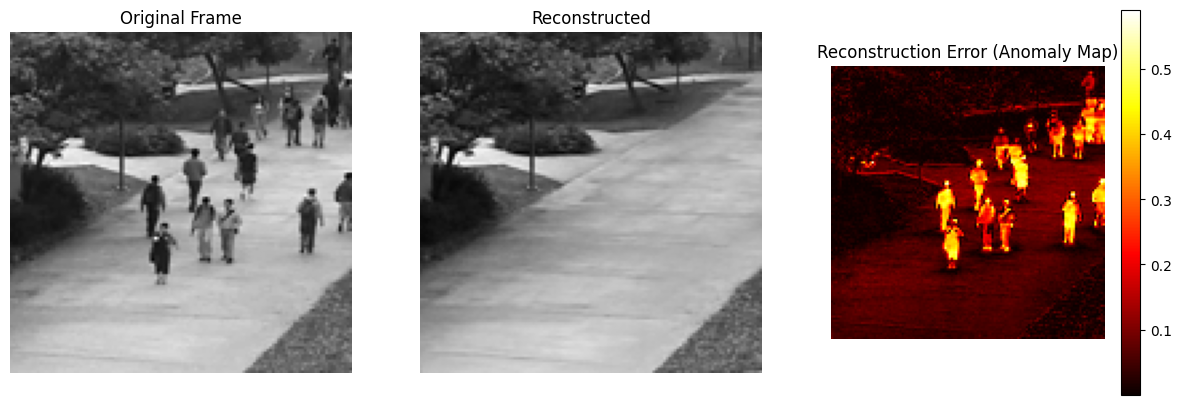

Reconstruction error: mean=0.066110, max=0.590029, std=0.087496


In [60]:
# Reconstruction error analysis on test set
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import kstest, norm

model.eval()
examples = []
with torch.no_grad():
    for batch in test_loader:
        if len(batch) == 3:
            x, x_target, paths = batch
        else:
            x, x_target = batch
            paths = None
        x = x.to(DEVICE)
        x_hat, _, _ = model(x)
        # Reconstruction error (not residual noise)
        recon_error = (x - x_hat).cpu().numpy()
        examples.append(
            (
                x.cpu().numpy(),
                x_hat.cpu().numpy(),
                recon_error,
                paths if paths is not None else [],
            )
        )
        if len(examples) >= 3:
            break

# visualize first example
x_np, x_hat_np, error_np, _paths = examples[0]
idx = 0
original = x_np[idx, 0]
reconstructed = x_hat_np[idx, 0]
error = np.abs(error_np[idx, 0])

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(original, cmap="gray")
plt.title("Original Frame")
plt.axis("off")
plt.subplot(1, 3, 2)
plt.imshow(reconstructed, cmap="gray")
plt.title("Reconstructed")
plt.axis("off")
plt.subplot(1, 3, 3)
plt.imshow(error, cmap="hot")
plt.title("Reconstruction Error (Anomaly Map)")
plt.colorbar()
plt.axis("off")
plt.show()

# Statistics
error_flat = error.flatten()
print(
    f"Reconstruction error: mean={error_flat.mean():.6f}, max={error_flat.max():.6f}, std={error_flat.std():.6f}"
)

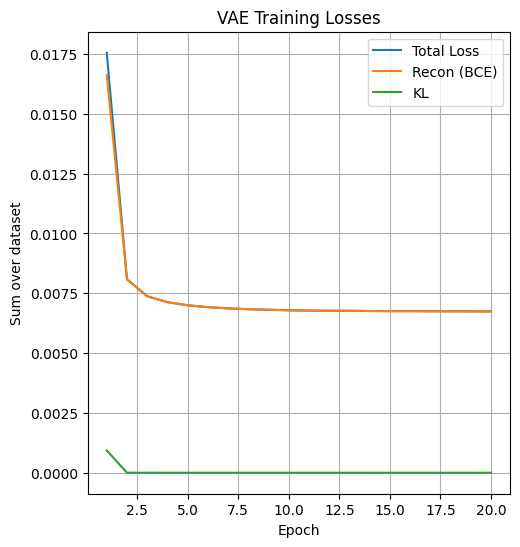

In [61]:
# Plot training curves
import matplotlib.pyplot as plt

# history is a list of dicts: {epoch, loss, recon, kl, bpp}
ep = [h["epoch"] for h in history]
loss = [h["loss"] for h in history]
recon = [h["recon"] for h in history]
kl = [h["kl"] for h in history]

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(ep, loss, label="Total Loss")
plt.plot(ep, recon, label="Recon (BCE)")
plt.plot(ep, kl, label="KL")
plt.xlabel("Epoch")
plt.ylabel("Sum over dataset")
plt.title("VAE Training Losses")
plt.legend()
plt.grid(True)

### Детекция аномалий через ошибку реконструкции

VAE обучен только на кадрах с пешеходами из `Train`. На `Test` (содержит аномалии: велосипеды/машины):
- **Пешеходы** — VAE хорошо реконструирует → низкая ошибка
- **Велосипеды/машины** — VAE не знает эти объекты → высокая ошибка реконструкции

Метрики:
- **MSE** (средняя квадратичная ошибка по кадру) — выше для кадров с аномалиями
- **Max reconstruction error** — локализует аномальные регионы

Test frames: 7199 | mean score 0.332820
MSE: mean=0.009051, max=0.030396
Max error: mean=0.647539, max=0.936537


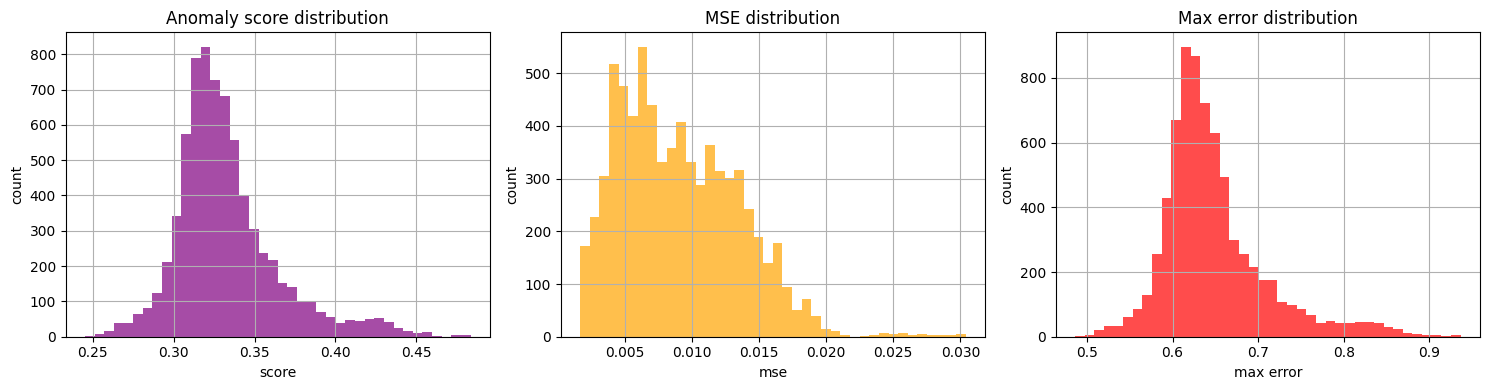


Top-5 frames by anomaly score:
1. Score=0.483627, MSE=0.015358, Max=0.936537
2. Score=0.483555, MSE=0.016742, Max=0.933626
3. Score=0.483157, MSE=0.015863, Max=0.934587
4. Score=0.482567, MSE=0.016389, Max=0.932357
5. Score=0.482250, MSE=0.016767, Max=0.930967


In [62]:
# Per-frame anomaly scoring on Test
from scipy.stats import kstest

# Recreate test_loader with return_path=True to ensure paths are returned
test_ds_with_paths = UCSDPedDataset(
    test_files, add_noise=False, return_path=True
)
test_loader_with_paths = DataLoader(
    test_ds_with_paths, batch_size=BATCH_SIZE, shuffle=False, num_workers=0
)

model.eval()
frame_scores = []  # list of dicts per frame
with torch.no_grad():
    for batch in tqdm(
        test_loader_with_paths, desc="Scoring Test", leave=False
    ):
        if len(batch) == 3:
            x, x_target, paths = batch
        else:
            x, x_target = batch
            paths = [None] * x.size(0)
        x = x.to(DEVICE)
        x_hat, _, _ = model(x)
        recon_error = torch.abs(x - x_hat).cpu().numpy()  # (B,1,H,W)
        # per-frame metrics
        for i in range(recon_error.shape[0]):
            err = recon_error[i, 0]
            mse_frame = float(np.mean(err**2))
            max_error = float(np.max(err))
            p95_error = float(np.percentile(err, 95))
            # Combined anomaly score
            score = mse_frame + 0.5 * max_error
            path_value = (
                paths[i]
                if (isinstance(paths, (list, tuple)) and i < len(paths))
                else None
            )
            frame_scores.append(
                {
                    "mse": mse_frame,
                    "max_error": max_error,
                    "p95_error": p95_error,
                    "score": float(score),
                    "path": path_value,
                }
            )

# Summary
scores = np.array([f["score"] for f in frame_scores])
mses = np.array([f["mse"] for f in frame_scores])
max_errors = np.array([f["max_error"] for f in frame_scores])
print(f"Test frames: {len(frame_scores)} | mean score {scores.mean():.6f}")
print(f"MSE: mean={mses.mean():.6f}, max={mses.max():.6f}")
print(f"Max error: mean={max_errors.mean():.6f}, max={max_errors.max():.6f}")

plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plt.hist(scores, bins=40, color="purple", alpha=0.7)
plt.title("Anomaly score distribution")
plt.xlabel("score")
plt.ylabel("count")
plt.grid(True)
plt.subplot(1, 3, 2)
plt.hist(mses, bins=40, color="orange", alpha=0.7)
plt.title("MSE distribution")
plt.xlabel("mse")
plt.ylabel("count")
plt.grid(True)
plt.subplot(1, 3, 3)
plt.hist(max_errors, bins=40, color="red", alpha=0.7)
plt.title("Max error distribution")
plt.xlabel("max error")
plt.ylabel("count")
plt.grid(True)
plt.tight_layout()
plt.show()

# Show top-5 highest anomaly frames
top_idx = np.argsort(scores)[-5:][::-1]
print("\nTop-5 frames by anomaly score:")
for rank, idx in enumerate(top_idx, 1):
    print(
        f"{rank}. Score={scores[idx]:.6f}, MSE={mses[idx]:.6f}, Max={max_errors[idx]:.6f}"
    )

Total frame_scores entries: 7199
Entries with non-None paths: 7199

Frames with GT masks found: 2000

Visualizing 5 frames with highest anomaly scores:
  1. Score=0.483627, MSE=0.015358
     Path: ./data/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test024/110.tif
     GT: ./data/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test024_gt/110.bmp
  2. Score=0.483555, MSE=0.016742
     Path: ./data/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test024/103.tif
     GT: ./data/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test024_gt/103.bmp
  3. Score=0.483157, MSE=0.015863
     Path: ./data/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test024/109.tif
     GT: ./data/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test024_gt/109.bmp
  4. Score=0.482567, MSE=0.016389
     Path: ./data/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test024/102.tif
     GT: ./data/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test024_gt/102.bmp
  5. Score=0.482250, MSE=0.016767
     Path: ./data/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test024/104.tif
     GT:

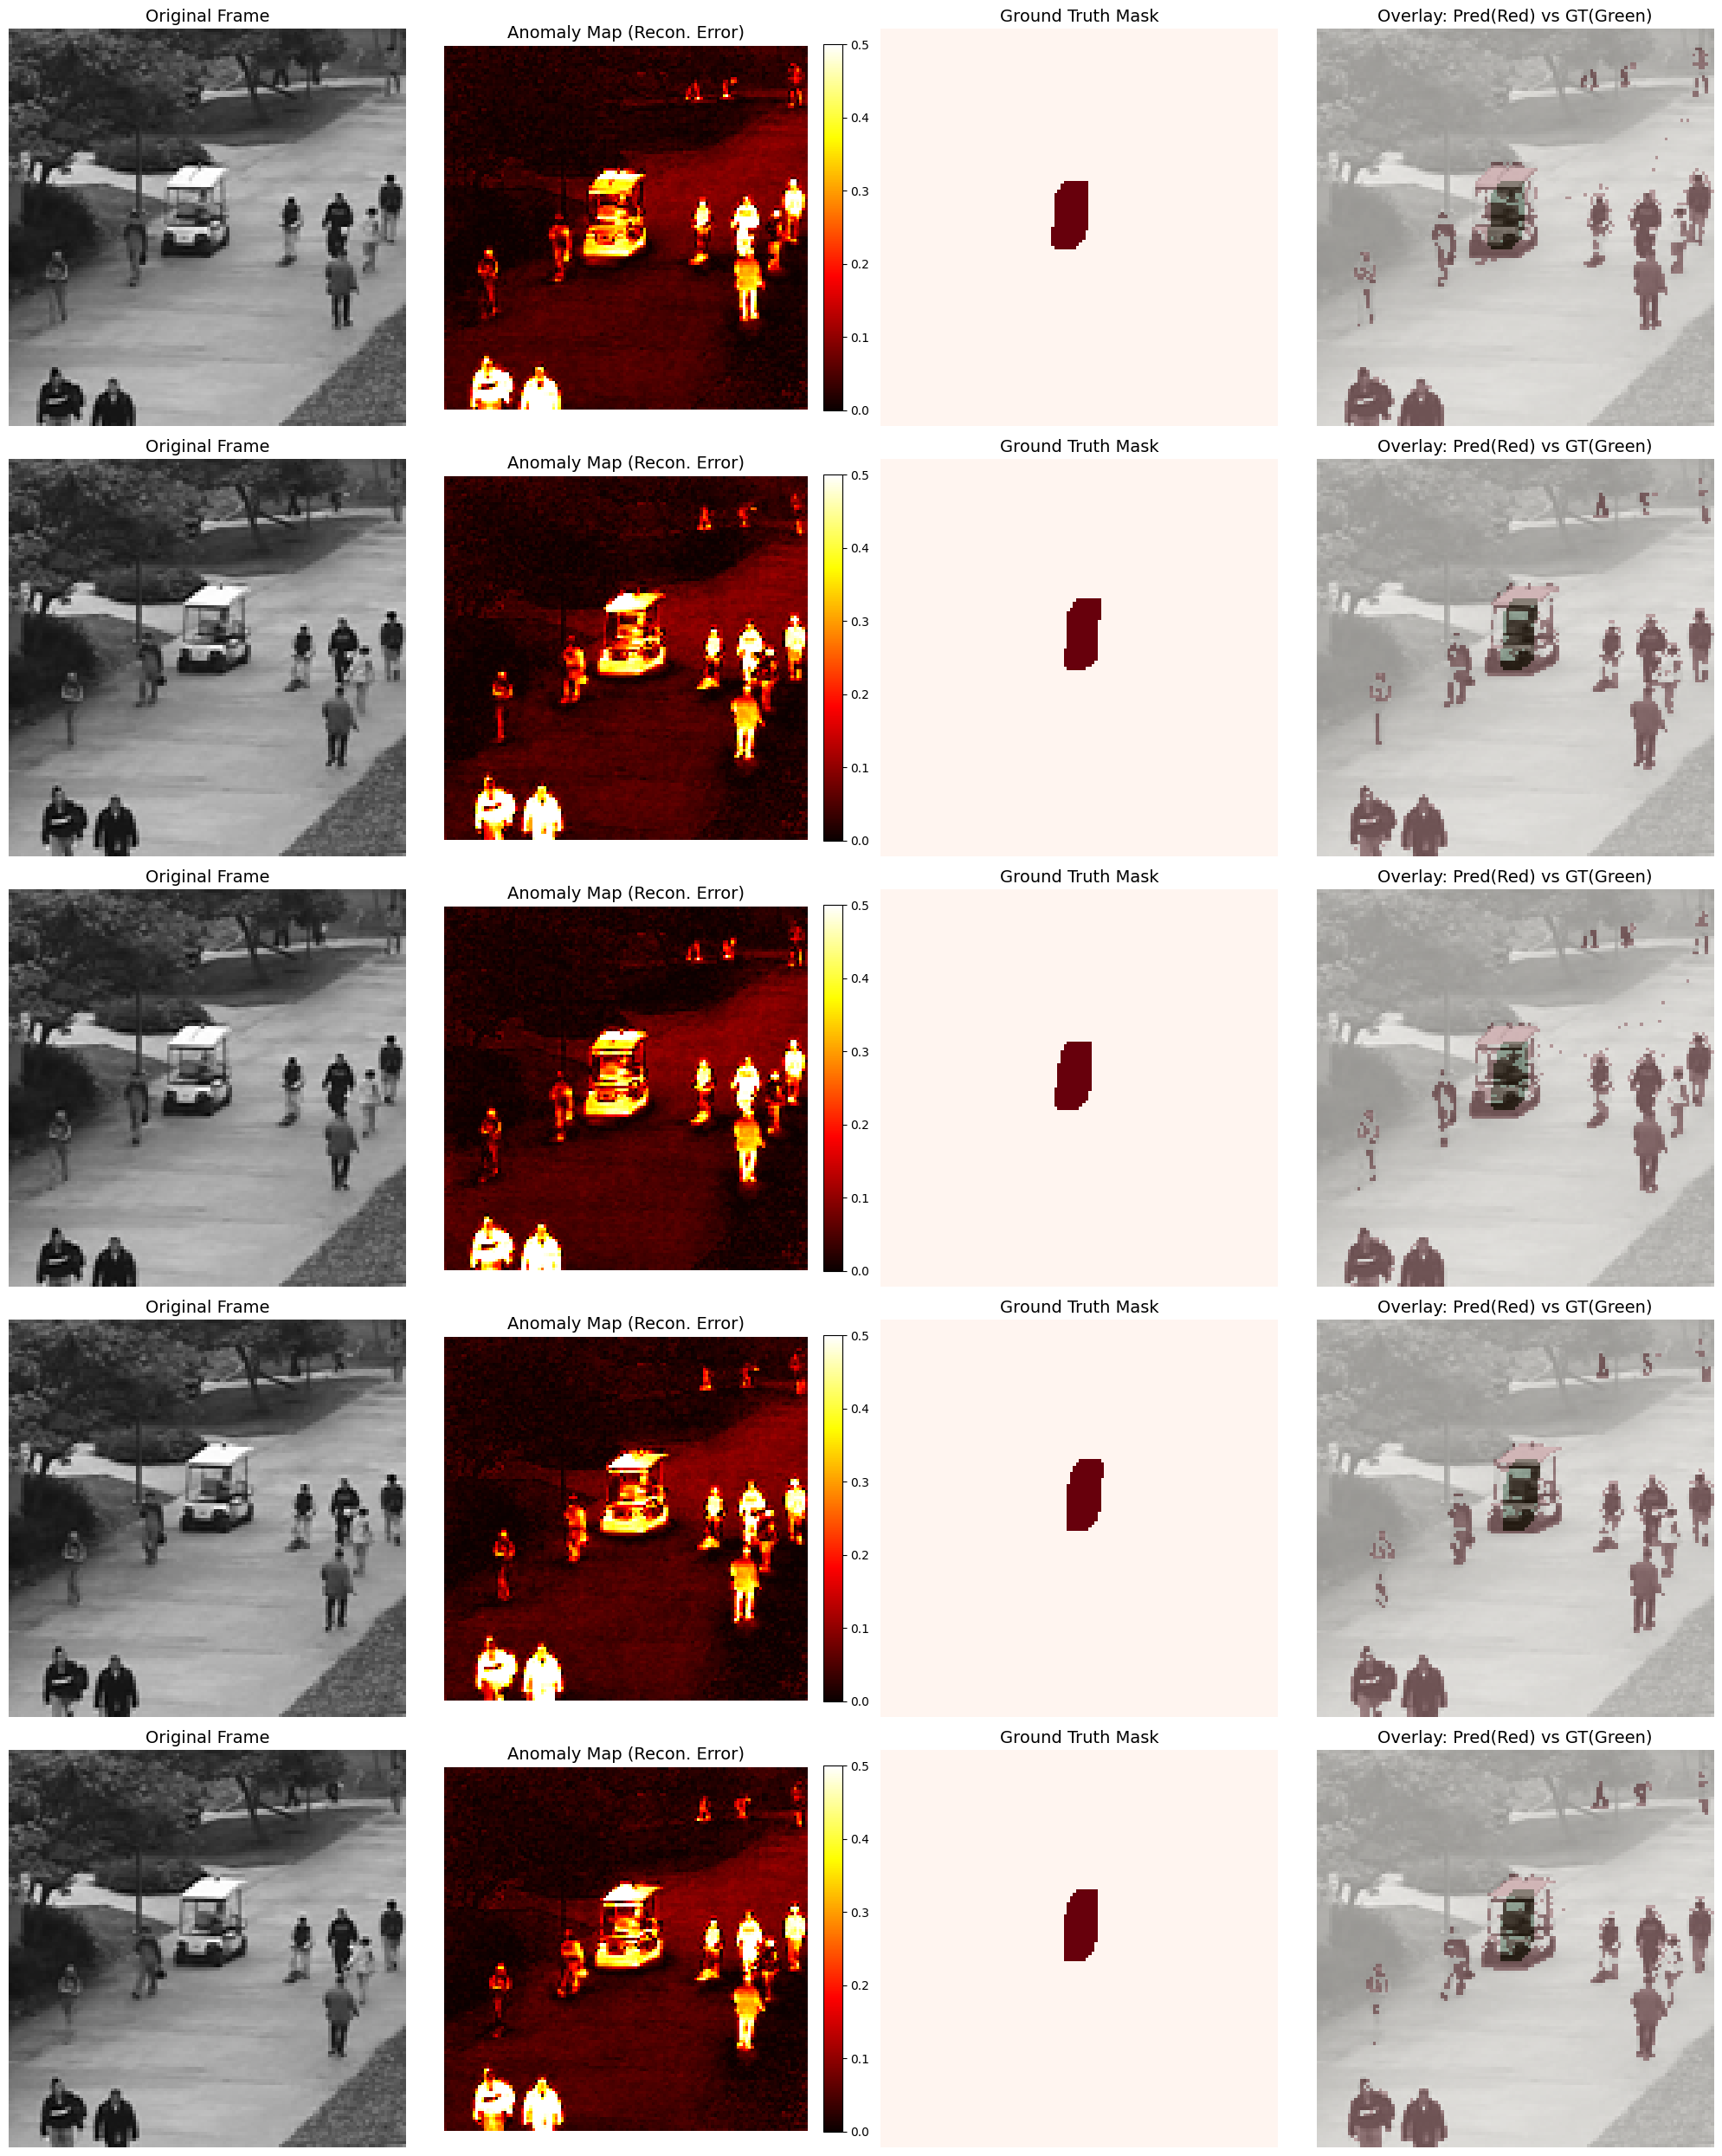

In [63]:
# Visual comparison: predicted anomaly map vs ground-truth (if available)
from glob import glob


def find_gt_mask_for_frame(frame_path: str):
    # Try common ground-truth locations and extensions
    if not frame_path:
        return None
    seq_dir = os.path.dirname(frame_path)
    parent = os.path.dirname(seq_dir)
    stem = os.path.splitext(os.path.basename(frame_path))[0]

    # For UCSD dataset, GT masks are in {TestXXX}_gt folders
    # Pattern: Test/Test001/001.tif -> Test/Test001_gt/001.bmp
    test_folder_name = os.path.basename(seq_dir)  # e.g., "Test001"
    gt_folder_name = test_folder_name + "_gt"
    gt_folder = os.path.join(parent, gt_folder_name)

    candidate_dirs = [
        gt_folder,  # Most likely location for UCSD
        os.path.join(seq_dir, "GT"),
        os.path.join(seq_dir, "gt"),
        os.path.join(parent, "GT"),
        os.path.join(parent, "gt"),
    ]

    exts = [".bmp", ".png", ".tif", ".tiff", ".jpg"]
    for d in candidate_dirs:
        if not os.path.isdir(d):
            continue
        # 1) exact same stem
        for e in exts:
            p = os.path.join(d, stem + e)
            if os.path.exists(p):
                return p
        # 2) any file containing the numeric frame id
        digits = "".join([c for c in stem if c.isdigit()])
        if digits:
            matches = [
                p
                for p in glob(os.path.join(d, "*"))
                if digits in os.path.basename(p)
            ]
            if matches:
                return matches[0]
    return None


# helper to preprocess a path like dataset transform
prep_tf = transforms.Compose(
    [
        transforms.Grayscale(num_output_channels=1),
        transforms.CenterCrop(128),
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
    ]
)

# Debug: check if frame_scores exists and has paths
print(f"Total frame_scores entries: {len(frame_scores)}")
paths_with_values = sum(1 for f in frame_scores if f.get("path") is not None)
print(f"Entries with non-None paths: {paths_with_values}")

# Filter only frames that have GT masks
frames_with_gt = []
for i, f in enumerate(frame_scores):
    p = f.get("path")
    if p is not None and isinstance(p, str) and os.path.exists(p):
        gt_path = find_gt_mask_for_frame(p)
        if gt_path is not None and os.path.exists(gt_path):
            frames_with_gt.append((i, f["score"], p, gt_path))

print(f"\nFrames with GT masks found: {len(frames_with_gt)}")

if len(frames_with_gt) == 0:
    print(
        "No frames with GT masks found. Showing top anomaly frames without GT."
    )
    # Fallback to original logic
    ranked = np.argsort(scores)[-100:][::-1]
    valid_paths = []
    for i in ranked:
        p = frame_scores[i].get("path")
        if p is not None and isinstance(p, str) and os.path.exists(p):
            valid_paths.append(p)
        if len(valid_paths) >= 5:
            break
    frames_to_show = [(p, None) for p in valid_paths]
else:
    # Sort by anomaly score and take top 5 with GT
    frames_with_gt.sort(key=lambda x: x[1], reverse=True)
    frames_to_show = [(p, gt) for _, _, p, gt in frames_with_gt[:5]]

if len(frames_to_show) == 0:
    print("No valid frame paths available to visualize.")
else:
    print(
        f"\nVisualizing {len(frames_to_show)} frames with highest anomaly scores:"
    )
    for i, (p, gt) in enumerate(frames_to_show):
        idx = next(
            (j for j, f in enumerate(frame_scores) if f.get("path") == p), None
        )
        if idx is not None:
            print(
                f"  {i+1}. Score={frame_scores[idx]['score']:.6f}, MSE={frame_scores[idx]['mse']:.6f}"
            )
            print(f"     Path: {p}")
            if gt:
                print(f"     GT: {gt}")

    fig, axes = plt.subplots(
        nrows=len(frames_to_show),
        ncols=4,
        figsize=(20, 5 * len(frames_to_show)),
    )
    if len(frames_to_show) == 1:
        axes = np.expand_dims(axes, 0)

    row_rendered = 0
    for row, (p, gt_path) in enumerate(frames_to_show):
        try:
            with Image.open(p) as im:
                x = prep_tf(im).unsqueeze(0).to(DEVICE)  # (1,1,H,W)
        except Exception as e:
            print(f"Skip {p}: {e}")
            continue
        with torch.no_grad():
            x_hat, _, _ = model(x)
        x_np = x.squeeze(0).cpu().numpy()[0]
        xhat_np = x_hat.squeeze(0).cpu().numpy()[0]
        # predicted anomaly map as absolute reconstruction error
        pred_map = np.abs(x_np - xhat_np)

        # load GT mask
        gt_np = None
        if gt_path is not None and os.path.exists(gt_path):
            try:
                with Image.open(gt_path) as gtim:
                    gtim = gtim.convert("L").resize((IMG_SIZE, IMG_SIZE))
                    gt_np = np.array(gtim).astype(np.float32) / 255.0
                    gt_np = (gt_np > 0.5).astype(np.float32)
            except Exception as e:
                print(f"Failed to load GT {gt_path}: {e}")
                gt_np = None

        # visualize
        axes[row, 0].imshow(x_np, cmap="gray")
        axes[row, 0].set_title("Original Frame", fontsize=14)
        axes[row, 0].axis("off")

        im1 = axes[row, 1].imshow(pred_map, cmap="hot", vmin=0, vmax=0.5)
        axes[row, 1].set_title("Anomaly Map (Recon. Error)", fontsize=14)
        axes[row, 1].axis("off")
        fig.colorbar(im1, ax=axes[row, 1], fraction=0.046, pad=0.04)

        if gt_np is not None:
            axes[row, 2].imshow(gt_np, cmap="Reds", vmin=0, vmax=1)
            axes[row, 2].set_title("Ground Truth Mask", fontsize=14)
            axes[row, 2].axis("off")

            # Overlay comparison
            axes[row, 3].imshow(x_np, cmap="gray")
            # Threshold predicted map for better visualization
            pred_thresh = (pred_map > np.percentile(pred_map, 90)).astype(
                float
            )
            axes[row, 3].imshow(pred_thresh, cmap="Reds", alpha=0.4)
            axes[row, 3].imshow(gt_np, cmap="Greens", alpha=0.3)
            axes[row, 3].set_title(
                "Overlay: Pred(Red) vs GT(Green)", fontsize=14
            )
            axes[row, 3].axis("off")
        else:
            axes[row, 2].text(0.5, 0.5, "No GT mask", ha="center", va="center")
            axes[row, 2].set_axis_off()
            axes[row, 3].imshow(x_np, cmap="gray")
            axes[row, 3].imshow(
                pred_map, cmap="hot", alpha=0.5, vmin=0, vmax=0.5
            )
            axes[row, 3].set_title("Predicted Overlay", fontsize=14)
            axes[row, 3].axis("off")
        row_rendered += 1

    if row_rendered == 0:
        print("Could not render any visualization rows.")
    plt.tight_layout()
    plt.show()